In [1]:
from experimentscommons.nb_parameters import EXPERIMENT_INSTANCE_ID as experiment_id_key
from box import Box
import mlflow

In [2]:
EXPERIMENT_INSTANCE_ID = '2ab58ce28e2d4b439cb5cd6803eed263'
CORES_AVAILABLE = 8

In [3]:
# Parameters
EXPERIMENT_INSTANCE_ID = "67f9efb0b6894d3bade3bfc105731b0d"
CORES_AVAILABLE = 8


In [4]:
experiment_id = locals()[experiment_id_key] if experiment_id_key in locals() else None

if experiment_id == None:
    raise Error("No experiment id")

In [5]:
run = mlflow.start_run(run_id=experiment_id)

In [6]:
params = Box(run.data.params,
            box_recast={
                'max_depth': int,
                'n_trees': int,
                'cv': int,
                'cv_repeats': int,
                'n_jobs': int,
                'n_gen': int,
                'pop_size': int,
                'debug': bool
            })

In [7]:
params['debug'] = False

In [8]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

# Load data

In [9]:
train_data = pd.read_csv(params['TRAIN_PATH'])
test_data = pd.read_csv(params['TEST_PATH'])
x_train = train_data.drop('TARGET', axis=1).values
y_train = train_data['TARGET'].values
x_test = test_data.drop('TARGET', axis=1).values
y_test = test_data['TARGET'].values

# Train base

In [10]:
from sklearn.neighbors import kneighbors_graph, KNeighborsClassifier, NearestNeighbors

In [11]:
from more_itertools import grouper
from itertools import product
from scipy.spatial.distance import euclidean
from toolz.curried import pipe, reduce, map, filter

In [12]:
def list_with_repeated_elements(input_list, n_repeated):
    return [val for val in input_list for _ in range(n_repeated)]

In [13]:
from rules.classification.utils import covered_by_statements
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, ShuffleSplit, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.metrics import make_scorer

In [14]:
from loguru import logger

In [15]:
feature_min = np.min(x_train, axis=0)
feature_max = np.max(x_train, axis=0)

In [16]:
from rules.classification.competence_region_ensemble import SimpleCompetenceRegionEnsemble

In [17]:
from sklearn.neighbors import NearestCentroid, NearestNeighbors

In [18]:
def nn_wrapper(nn):
    return Box({
     "predict": lambda x: nn.kneighbors(x, n_neighbors=nn.n_samples_fit_, return_distance=False)   
    })
    
    

In [19]:
def get_nodes_usage(clf, x):
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    node_indicator = clf.decision_path(x)
    leaf_id = clf.apply(x)

    
    usage_by_sample = {}
    for sample_id in range(len(x)):
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
        ]

        nodes_used_for_this_sample = []
        features_used_for_this_sample = []
        for node_id in node_index:
            # continue to the next node if it is a leaf node
            if leaf_id[sample_id] == node_id:
                continue


            nodes_used_for_this_sample.append(node_id)
            features_used_for_this_sample.append(feature[node_id])

        usage_by_sample[tuple(x[sample_id])] = {
            'nodes': nodes_used_for_this_sample,
            'features': features_used_for_this_sample
        }
        
    return usage_by_sample

In [20]:
import copy
import wrapt

In [21]:
class MlFlowDTWrapper(wrapt.ObjectProxy):

    
    def predict(self, x, *args, **kwargs):
        self.usage_by_sample = get_nodes_usage(self.__wrapped__, x)
        return self.__wrapped__.predict(x, *args, **kwargs)
    
    def __copy__(self):
        return MlFlowDTWrapper(copy.copy(self.__wrapped__))

    def __deepcopy__(self, memo):
        return MlFlowDTWrapper(copy.deepcopy(self.__wrapped__, memo))

In [22]:
def create_estimator(centroids, depths, metrics=False): 
    n_trees = centroids.shape[0]
    activated_trees_indices = np.nonzero(depths)[0]

    active_centroids = centroids[activated_trees_indices]
    active_depths = depths[activated_trees_indices]
    
    space_classifier = NearestNeighbors()
    space_classifier.fit(active_centroids)

    if metrics:
        model = SimpleCompetenceRegionEnsemble(
            None,
            {label:MlFlowDTWrapper(DecisionTreeClassifier(max_depth=depth, random_state=42)) for label, depth in enumerate(active_depths)}
        )
    else:
        model = SimpleCompetenceRegionEnsemble(
            None,
            {label:DecisionTreeClassifier(max_depth=depth, random_state=42) for label, depth in enumerate(active_depths)}
        )

    return model, space_classifier


In [23]:
def find_closeset_val(arr, val):
    return np.argmin(np.abs(np.array(arr) - val))

# Problem

Wektor = $[\text{wspolrzedne}_n, \text{depth}_n, \text{wlaczony}_n]$

In [24]:
n_dim = x_train.shape[1] 
n_trees = params.n_trees

In [25]:
from pymoo.factory import get_sampling, get_crossover, get_mutation


In [26]:
import numpy as np
from toolz.curried import pipe, map, reduce, filter
from pymoo.core.problem import ElementwiseProblem
from loguru import logger


class MyProblem(ElementwiseProblem):

    def __init__(self, n_trees, x_train, y_train, max_tree_depth, **kwargs):
        n_dim = x_train.shape[1]
        
        super().__init__(
            n_var=n_trees*n_dim + n_trees, # each centroid * number of features + depths + on/off
             n_obj=1, # accuracy
             n_constr=0,
             xl=list(np.min(x_train, axis=0)) * n_trees + n_trees * [-0.5],
             xu=list(np.max(x_train, axis=0)) * n_trees + n_trees * [max_tree_depth + 0.5],
            **kwargs
        )
        
        self.n_trees = n_trees
        self.x_train = x_train
        self.y_train = y_train
        self.n_dim = n_dim
        self.max_tree_depth = max_tree_depth
        
    def _evaluate(self, individual, out, *args, **kwargs):
        n_coordinates_in_individual = self.n_dim * self.n_trees
        centroid_coordinates = individual[:n_coordinates_in_individual]
        
        individual_as_centroids = pipe(
            centroid_coordinates,
            lambda x: grouper(x, self.n_dim),
            list,
            np.array,
            np.nan_to_num
        )
        
        tree_depths_continous = individual[-self.n_trees:]
        possible_tree_depths = list(range(self.max_tree_depth + 1))
        
        tree_depths = np.array([find_closeset_val(possible_tree_depths, td) for td in tree_depths_continous])

        if np.all(tree_depths==0):
            out["F"] = 1
        else:
            model, space_classifier = create_estimator(individual_as_centroids, tree_depths)

            skf = RepeatedKFold(n_splits=params['cv'], n_repeats=params['cv_repeats'], random_state=42)
            scores = cross_validate(model, self.x_train, self.y_train, scoring='accuracy', cv=skf, fit_params={
            'competence_region_classifier': nn_wrapper(space_classifier)
            })
            
            if params.debug:
                print(f"Depths = {tree_depths}, acc = {scores['test_score'].mean()}")

            activated_trees_count = np.count_nonzero(tree_depths)
            out["F"] = eval(params.eval_func, {
                "mean_acc": scores['test_score'].mean(),
                "activated_trees_count": activated_trees_count,
                "max_trees": self.n_trees
            })



In [27]:
import sys
logger.remove()
logger.add(sys.stderr, level="INFO")

1

In [28]:
from collections import defaultdict
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import starmap_parallelized_eval
from multiprocessing.pool import ThreadPool, Pool


pool = Pool(CORES_AVAILABLE)

problem = MyProblem(params.n_trees, x_train, y_train, params.max_depth, 
                    runner=pool.starmap, func_eval=starmap_parallelized_eval
                   )

 
res = minimize(problem,
           GA(
               pop_size=params['pop_size'],
               verbose=True,
               seed=42,
                eliminate_duplicates=True
           ),
           ("n_gen", params['n_gen']),
           verbose=True,
               save_history=True,
           seed=42)

pool.close()

n_gen |  n_eval |     fopt     |     favg    
    1 |      50 |  0.900369349 |  1.041270068


    2 |     100 |  0.900369349 |  0.992519255


    3 |     150 |  0.842637644 |  0.953961194


    4 |     200 |  0.842637644 |  0.928444204


    5 |     250 |  0.842632719 |  0.904524771


    6 |     300 |  0.741938343 |  0.874045405


    7 |     350 |  0.741938343 |  0.846082734


    8 |     400 |  0.741938343 |  0.823017039


    9 |     450 |  0.739801044 |  0.794417217


   10 |     500 |  0.714562198 |  0.774019797


   11 |     550 |  0.687747464 |  0.748207032


   12 |     600 |  0.648256673 |  0.730264552


   13 |     650 |  0.640495420 |  0.707852950


   14 |     700 |  0.595420073 |  0.677251059


   15 |     750 |  0.591234118 |  0.650766079


   16 |     800 |  0.547532749 |  0.620683739


   17 |     850 |  0.533502413 |  0.590775436


   18 |     900 |  0.533502413 |  0.574612134


   19 |     950 |  0.530744608 |  0.553508914


   20 |    1000 |  0.496853147 |  0.543871368


   21 |    1050 |  0.485595391 |  0.539384024


   22 |    1100 |  0.446853147 |  0.527884862


   23 |    1150 |  0.446853147 |  0.512606422


   24 |    1200 |  0.433527036 |  0.486828228


   25 |    1250 |  0.433527036 |  0.473203093


   26 |    1300 |  0.429301684 |  0.449448833


   27 |    1350 |  0.403161627 |  0.442508815


   28 |    1400 |  0.402462326 |  0.436832857


   29 |    1450 |  0.398256673 |  0.428468630


   30 |    1500 |  0.387053088 |  0.414600118


   31 |    1550 |  0.387053088 |  0.399420565


   32 |    1600 |  0.379306609 |  0.394372402


   33 |    1650 |  0.379306609 |  0.390027184


   34 |    1700 |  0.378607308 |  0.385841032


   35 |    1750 |  0.378607308 |  0.383370432


   36 |    1800 |  0.374362257 |  0.380688860


   37 |    1850 |  0.374362257 |  0.379426179


   38 |    1900 |  0.374362257 |  0.379000985


   39 |    1950 |  0.370171378 |  0.378476017


   40 |    2000 |  0.363168522 |  0.377549493


   41 |    2050 |  0.363168522 |  0.375662661


   42 |    2100 |  0.359676943 |  0.371940904


   43 |    2150 |  0.359676943 |  0.365958337


   44 |    2200 |  0.359676943 |  0.361827834


   45 |    2250 |  0.359676943 |  0.359789126


   46 |    2300 |  0.359676943 |  0.359676943


   47 |    2350 |  0.356874815 |  0.359620900


   48 |    2400 |  0.356874815 |  0.359564858


   49 |    2450 |  0.356874815 |  0.359508815


   50 |    2500 |  0.356874815 |  0.359396730


In [29]:
from sklearn.metrics import accuracy_score

In [30]:
res.exec_time

211.91247081756592

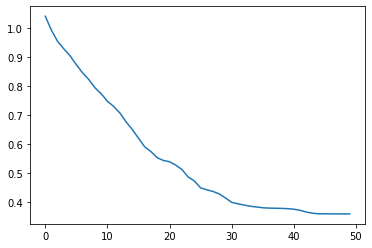

In [31]:
import matplotlib.pyplot as plt
val = [np.average(e.pop.get("F")) for e in res.history]
plt.plot(np.arange(len(val)), val)
plt.show()


In [32]:
for idx, vals in enumerate([e.pop.get("F") for e in res.history]):
    mlflow.log_metrics(
        {'min_function_value': np.min(vals), 
         'avg_function_value': np.average(vals),
         'max_function_value': np.max(vals)
        }, step=idx)

In [33]:
if res.X.ndim == 1:
    pareto_front = [res.X]
else:
    pareto_front = res.X

In [34]:
mlflow.log_metric("pareto", len(pareto_front))

In [35]:
def merge_usage_by_samples(clfs):
    usage_by_sample = {}
    
    for clf in clfs:
        try:
            usage_by_sample = usage_by_sample | clf.usage_by_sample
        except:
            pass
        
    return usage_by_sample

In [36]:
accs = []
stats = []
for individual in pareto_front:
    n_coordinates_in_individual = n_dim * n_trees
    centroid_coordinates = individual[:n_coordinates_in_individual]

    individual_as_centroids = pipe(
        centroid_coordinates,
        lambda x: grouper(x, n_dim),
        list,
        np.array,
        np.nan_to_num
    )
        
    tree_depths_continous = individual[-n_trees:]
    possible_tree_depths = list(range(params.max_depth + 1))
        
    tree_depths = np.array([find_closeset_val(possible_tree_depths, td) for td in tree_depths_continous])

    if params.debug:
        print(f"Depths = {tree_depths}")

    if np.all(tree_depths==0):
        continue
    else:
        model, space_classifier = create_estimator(individual_as_centroids, tree_depths, metrics=True)
        model.fit(x_train, y_train, competence_region_classifier=nn_wrapper(space_classifier))
    
        accs.append(accuracy_score(y_test, model.predict(x_test)))
        
        usage_by_samples = merge_usage_by_samples(model.clf_by_label.values())
        mean_number_of_nodes_used = np.mean([len(v['nodes']) for v in usage_by_samples.values()])
        mean_number_of_features_used = np.mean([len(set(v['features'])) for v in usage_by_samples.values()])
        stats.append({
            "mean_no_nodes_used": mean_number_of_nodes_used,
            "mean_no_features_used": mean_number_of_features_used,
            "ensemble_size": np.count_nonzero(tree_depths)
        })

In [37]:
best_model_idx, best_model_acc = max(enumerate(accs), key=lambda p: p[1])

In [38]:
mlflow.log_metric('best_training_model_acc', 1 - min(res.F))
mlflow.log_metric('best_model_acc', best_model_acc)

In [39]:
for key, val in stats[best_model_idx].items():
    mlflow.log_metric(key, val)

In [40]:
stats[best_model_idx]

{'mean_no_nodes_used': 1.3943661971830985,
 'mean_no_features_used': 1.3943661971830985,
 'ensemble_size': 6}

In [41]:
accs

[0.954225352112676]

In [42]:
import json

In [43]:
mlflow.end_run()